In [32]:
# 模型训练
import numpy as np
import pandas as pd
import os
import tqdm
import platform

encodingType = 'ANSI' if platform.system() == 'Windows' else'gb18030'

base_path = 'stock'

market_map = {'主板':0, '中小板':1}
exchange_map = {'SZSE':0, 'SSE':1}
is_hs_map = {'S':0, 'N':1, 'H':2}

area_map = {'深圳': 0, '北京': 1, '吉林': 2, '江苏': 3, '辽宁': 4, '广东': 5, '安徽': 6, '四川': 7, '浙江': 8,
            '湖南': 9, '河北': 10, '新疆': 11, '山东': 12, '河南': 13, '山西': 14, '江西': 15, '青海': 16,
            '湖北': 17, '内蒙': 18, '海南': 19, '重庆': 20, '陕西': 21, '福建': 22, '广西': 23, '天津': 24,
            '云南': 25, '贵州': 26, '甘肃': 27, '宁夏': 28, '黑龙江': 29, '上海': 30, '西藏': 31}

industry_map = {'银行': 0, '全国地产': 1, '生物制药': 2, '环境保护': 3, '区域地产': 4, '酒店餐饮': 5, '运输设备': 6,
                '综合类': 7, '建筑工程': 8, '玻璃': 9, '家用电器': 10, '文教休闲': 11, '其他商业': 12, '元器件': 13,
                'IT设备': 14, '其他建材': 15, '汽车服务': 16, '火力发电': 17, '医药商业': 18, '汽车配件': 19, '广告包装': 20,
                '轻工机械': 21, '新型电力': 22, '饲料': 23, '电气设备': 24, '房产服务': 25, '石油加工': 26, '铅锌': 27, '农业综合': 28,
                '批发业': 29, '通信设备': 30, '旅游景点': 31, '港口': 32, '机场': 33, '石油贸易': 34, '空运': 35, '医疗保健': 36,
                '商贸代理': 37, '化学制药': 38, '影视音像': 39, '工程机械': 40, '软件服务': 41, '证券': 42, '化纤': 43, '水泥': 44,
                '专用机械': 45, '供气供热': 46, '农药化肥': 47, '机床制造': 48, '多元金融': 49, '百货': 50, '中成药': 51, '路桥': 52,
                '造纸': 53, '食品': 54, '黄金': 55, '化工原料': 56, '矿物制品': 57, '水运': 58, '日用化工': 59, '机械基件': 60,
                '汽车整车': 61, '煤炭开采': 62, '铁路': 63, '染料涂料': 64, '白酒': 65, '林业': 66, '水务': 67, '水力发电': 68,
                '互联网': 69, '旅游服务': 70, '纺织': 71, '铝': 72, '保险': 73, '园区开发': 74, '小金属': 75, '铜': 76, '普钢': 77,
                '航空': 78, '特种钢': 79, '种植业': 80, '出版业': 81, '焦炭加工': 82, '啤酒': 83, '公路': 84, '超市连锁': 85,
                '钢加工': 86, '渔业': 87, '农用机械': 88, '软饮料': 89, '化工机械': 90, '塑料': 91, '红黄酒': 92, '橡胶': 93, '家居用品': 94,
                '摩托车': 95, '电器仪表': 96, '服饰': 97, '仓储物流': 98, '纺织机械': 99, '电器连锁': 100, '装修装饰': 101, '半导体': 102,
                '电信运营': 103, '石油开采': 104, '乳制品': 105, '商品城': 106, '公共交通': 107, '船舶': 108, '陶瓷': 109}

# 数据读取

In [33]:
# 首先是上市公司数据读取，这里在对是否是ST公司判断中有点小bug，
# 目前是ST的公司不代表之前是ST，目前不是ST的也不代表之前是ST。
def JudgeST(x):
    return 1 if 'ST' in x else 0

col = ['open', 'high', 'low', 'pre_close']

# 获取macd平均值
def GetMA(df, col_name, rolling_day):
    df[f'{col_name}_{str(rolling_day)}'] = df[col_name].rolling(rolling_day).mean()
    return df

company_info = pd.read_csv(os.path.join(base_path, 'company_info.csv'), encoding=encodingType)
company_info['is_ST'] = company_info['name'].apply(JudgeST)
# 丢弃一些多余的信息
company_info.drop(columns=['index', 'symbol', 'fullname'], axis='columns', inplace=True)
company_info.dropna(inplace=True)
company_info['market'] = company_info['market'].map(market_map)
company_info['exchange'] = company_info['exchange'].map(exchange_map)
company_info['is_hs'] = company_info['is_hs'].map(is_hs_map)


# 读取指数信息
stock_index_info = pd.DataFrame()
index = ['000001.SH', '000016.SH', '000002.SH', '399001.SZ', '399007.SZ', '399008.SZ', '399101.SZ', '399102.SZ']
for ts_code in index:
    try:
        tmp_df = pd.read_csv(os.path.join(base_path, 'OldData', f'{ts_code}_NormalData.csv'))
    except Exception:
        print('Error when try to read csv: 'f'{ts_code}_NormalData.csv')
        continue
    else:
        # 特征工程
        # tmp_df = FeatureEngineering(tmp_df)
        stock_index_info = pd.concat((stock_index_info, tmp_df))
tmp_list = list(tmp_df['trade_date'].sort_values())
date_map = dict(zip(tmp_list, range(len(tmp_list))))

# 读取股票交易信息
stock_info = pd.DataFrame()
remove_stock = []
tmp_list = []
# tqdm是 Python进度条库,可以在 Python长循环中添加一个进度提示信息
for ts_code in tqdm.tqdm(company_info['ts_code']):
    try:
        tmp_df = pd.read_csv(os.path.join(base_path, 'OldData', f'{ts_code}_NormalData.csv'))
    except Exception:
        # print('Error when try to read csv: 'f'{ts_code}_NormalData.csv')
        continue
    else:
        # 还需要去除一些停牌时间很久的企业，后期加
        if len(tmp_df) < 50:  # 去除一些上市不久的企业
            print('刚上市不久企业: 'f'{ts_code}_NormalData.csv')
            remove_stock.append(ts_code)
            continue
        tmp_df = tmp_df.sort_values('trade_date', ascending=True).reset_index()
        #         提取均线信息
        #     for tmp_col in col:
        #         for rolling_day in [5, 10, 13, 21, 30]:
        #             tmp_df = GetMA(tmp_df, tmp_col, rolling_day)
        # 特征工程
        #         tmp_df = FeatureEngineering(tmp_df)
        tmp_list.append(tmp_df)
stock_info = pd.concat(tmp_list)
ts_code_map = dict(zip(stock_info['ts_code'].unique(), range(stock_info['ts_code'].nunique())))
stock_info = stock_info.reset_index()
stock_info['ts_code_id'] = stock_info['ts_code'].map(ts_code_map)
stock_info.drop('index', axis=1, inplace=True)
stock_info['trade_date_id'] = stock_info['trade_date'].map(date_map)
ts_code_id = stock_info['ts_code_id']
trade_date_id = stock_info['trade_date_id']
stock_info['ts_date_id'] = (10000 + ts_code_id) * 10000 + trade_date_id
stock_info = stock_info.merge(company_info, how='left', on='ts_code')
stock_info_copy = stock_info.copy()

Error when try to read csv: 000002.SH_NormalData.csv


  0%|          | 0/301 [00:00<?, ?it/s]

100%|██████████| 301/301 [00:00<00:00, 1874.57it/s]


# 特征工程

In [36]:
# 特征工程
# 接下来是一些简单的特征工程，目前还没来得及做特征工程，后期做好会再更新。
# 首先是把收盘价、开盘价、最低价、最高价变换一个尺度（相当于盈亏比），若不转换直接放进去模型是很难学会的。
# 转换成盈亏比的话（相当于所有股票转化成同一个尺度了），模型更容易学会。
stock_info = stock_info_copy.copy()
col = ['close', 'open', 'high', 'low']
feature_col = []
for tmp_col in col:
    # 差值比上一个交易日的比例
    stock_info[f'{tmp_col}_transform'] = (stock_info[tmp_col] - stock_info['pre_close']) / stock_info['pre_close']
    feature_col.append(f'{tmp_col}_transform')

In [37]:

# 提取前5天收盘价与今天收盘价的盈亏比。
for i in range(5):
    tmp_df = stock_info[['ts_date_id', 'close']]
    tmp_df = tmp_df.rename(columns={'close': f'close_shift_{i + 1}'})
    feature_col.append(f'close_shift_{i + 1}')
    # 这里的代码有问题？
    tmp_df['ts_date_id'] = tmp_df['ts_date_id'] + i + 1
    # tmp_df['ts_date_id'] = tmp_df['ts_date_id'].drop(tmp_df['ts_date_id'].index[:i])

    stock_info = stock_info.merge(tmp_df, how='left', on='ts_date_id')
stock_info.drop('level_0', axis=1, inplace=True)
# stock_info.dropna(inplace=True)

for i in range(5):
    stock_info[f'close_shift_{i + 1}'] = (stock_info['close'] - stock_info[f'close_shift_{i + 1}']) / stock_info[f'close_shift_{i + 1}']

print('stock_info.size:%d' % stock_info.size)

stock_info.size:13254


# 标签制作

In [32]:
# 在标签制作时，如果一支股票在未来5天里最高增长大于5%，最大损失大于-3%，我们将其标签标记为1，其他标签标记为0。
# 在制作标签时为了防止股价拉到5%瞬间掉下来，我们加了一点容错（6%）。
# 这里做标签其实有点bug，这里没有考虑股票先涨到5%，再跌到-3%。因为我们的止盈点是5%，
# 如果先涨到5%我们卖了就不需要考虑后面的情况了。（这个后面再改）

# make_label
# stock_info = stock_info_copy.copy()
use_col = []
for i in range(5):
    tmp_df = stock_info[['ts_date_id', 'high', 'low']]
    tmp_df = tmp_df.rename(columns={'high': f'high_shift_{i + 1}', 'low': f'low_shift_{i + 1}'})

    use_col.extend((f'high_shift_{i + 1}', f'low_shift_{i + 1}'))
    tmp_df['ts_date_id'] = tmp_df['ts_date_id'] - i - 1
    # tmp_df['ts_date_id'] = tmp_df['ts_date_id'].drop(tmp_df['ts_date_id'].index[:i])
    stock_info = stock_info.merge(tmp_df, how='left', on='ts_date_id')

stock_info.dropna(inplace=True)

for i in range(5):
    stock_info[f'high_shift_{i + 1}'] = (stock_info[f'high_shift_{i + 1}'] - stock_info['close']) / stock_info['close']

    stock_info[f'low_shift_{i + 1}'] = (stock_info[f'low_shift_{i + 1}'] - stock_info['close']) / stock_info['close']


tmp_array = stock_info[use_col].values
max_increase = np.max(tmp_array, axis=1)
min_increase = np.min(tmp_array, axis=1)
stock_info['label_max'] = max_increase
stock_info['label_min'] = min_increase
stock_info['label_final'] = (stock_info['label_max'] > 0.06) & (stock_info['label_min'] > -0.03)
stock_info['label_final'] = stock_info['label_final'].apply(lambda x: int(x))
stock_info = stock_info.reset_index()
stock_info.drop('index', axis=1, inplace=True)
print('stock_info.size:%d' % stock_info.size)

# 模型训练

In [6]:
# 模型数据输入准备：这里我们选取了18年1月1日至19年4月5日的数据作为训练集，
# 19年4月6号至19年4月10号的数据作为验证集，
# 19年4月17日至19年12月18日的数据作为回测数据
# （这是一段黑暗的行情，看看我们的模型在黑暗的行情下有什么表现）。
trn_col = ['open', 'high', 'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount', 'ts_code_id'] + feature_col
label = 'label_final'
trn_date_min = 20180101
trn_date_max = 20190405
val_date_min = 20190406
val_date_max = 20190410
test_date_min = 20190417
test_date_max = 20191218

trn_data_idx = (stock_info['trade_date'] >= trn_date_min) & (stock_info['trade_date'] <= trn_date_max)
val_data_idx = (stock_info['trade_date'] >= val_date_min) & (stock_info['trade_date'] <= val_date_max)
test_data_idx = (stock_info['trade_date'] >= test_date_min) & (stock_info['trade_date'] <= test_date_max)

trn = stock_info[trn_data_idx][trn_col].values
trn_label = stock_info[trn_data_idx][label].values

val = stock_info[val_data_idx][trn_col].values
val_label = stock_info[val_data_idx][label].values

test = stock_info[test_data_idx][trn_col].values
test_label = stock_info[test_data_idx][label].values

In [7]:
print('rate of 0: %.4f, rate of 1: %.4f' % (np.sum(trn_label==0)/len(trn_label), np.sum(trn_label==1)/len(trn_label)))
print('trn data:%d, val data:%d, test data:%d' % (len(trn), len(val), len(test)))
print('number of features:%d' % len(trn_col))

rate of 0: nan, rate of 1: nan
trn data:0, val data:0, test data:0
number of features:19


C:\Users\dllss\AppData\Local\Temp\ipykernel_18360\231465913.py:1: RuntimeWarning: invalid value encountered in long_scalars
  print('rate of 0: %.4f, rate of 1: %.4f' % (np.sum(trn_label==0)/len(trn_label), np.sum(trn_label==1)/len(trn_label)))


In [8]:
# 可以发现样本中正负样本比为1：4，使用了19个特征。
# 模型训练时我们使用了LGB，还没有尝试其他模型，但是应该LGB就够了。

# 模型训练及评价
import lightgbm as lgb
from sklearn import metrics

param = {
    'num_leaves': 31,
    # 'n_estimatores': 3000,
    'min_data_in_leaf': 20,
    'objective': 'binary',
    # 'max_depth': 5,
    'learning_rate': 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    # "feature_fraction": 0.45,
    "bagging_freq": 1,
    # "bagging_fraction": 0.8,
    "bagging_seed": 11,
    "verbosity": -1
}
trn_data = lgb.Dataset(trn, trn_label)
val_data = lgb.Dataset(val, val_label)
num_round = 2000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets=[trn_data, val_data],
                verbose_eval=300,
                early_stopping_rounds=100)
oof_lgb = clf.predict(val, num_iteration=clf.best_iteration)
test_lgb = clf.predict(test, num_iteration=clf.best_iteration)

d:\Program Files\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
d:\Program Files\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


LightGBMError: Check failed: (num_data) > (0) at D:\a\1\s\python-package\compile\src\io\dataset.cpp, line 33 .


# 模型评价

In [ ]:
oof_lgb_final = np.round(oof_lgb)
print(metrics.accuracy_score(val_label, oof_lgb_final))
print(metrics.confusion_matrix(val_label, oof_lgb_final))
tp = np.sum(((oof_lgb_final == 1) & (val_label == 1)))
pp = np.sum(oof_lgb_final == 1)
print('sensitivity:%.3f'% (tp/(pp)))

NameError: name 'oof_lgb' is not defined

In [ ]:
thresh_hold = 0.6
oof_test_final = test_lgb >= thresh_hold
print(metrics.accuracy_score(test_label, oof_test_final))
print(metrics.confusion_matrix(test_label, oof_test_final))
tp = np.sum(((oof_test_final == 1) & (test_label == 1)))
pp = np.sum(oof_test_final == 1)
print('sensitivity:%.3f'% (tp/(pp)))

0.8530543382095755
[[41461     0]
 [ 7142     0]]
sensitivity:nan


C:\Users\dllss\AppData\Local\Temp\ipykernel_10640\3488924863.py:7: RuntimeWarning: invalid value encountered in long_scalars
  print('sensitivity:%.3f'% (tp/(pp)))


In [ ]:
test_postive_idx = np.argwhere(oof_test_final == 1).reshape(-1)
test_all_idx = np.argwhere(np.array(test_data_idx)).reshape(-1)

In [ ]:
# 查看选了哪些股票
tmp_col = ['ts_code', 'name', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'amount', 'is_ST', 'label_max', 'label_min', 'label_final']
# stock_info.iloc[test_all_idx[test_postive_idx]]

tmp_df = stock_info[tmp_col].iloc[test_all_idx[test_postive_idx]].reset_index()
# idx_tmp = tmp_df['is_ST'] == 0
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.095)
# idx_tmp = tmp_df['is_ST'] == 1
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.047)

tmp_df['is_limit_up'] = tmp_df['close'] == tmp_df['high']

buy_df = tmp_df[(tmp_df['is_limit_up']==False)].reset_index()
buy_df.drop(['index', 'level_0'], axis=1, inplace=True)

In [ ]:
print(len(buy_df), sum(buy_df['label_final']))

0 0


# 回测

In [ ]:
# stock_info.reset_index().head()
# 读取指数信息
index_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
tmp_idx = (index_df['trade_date'] >= test_date_min) & (index_df['trade_date'] <= test_date_max)
index_df = index_df.loc[tmp_idx].reset_index()
index_df.drop('index', axis=1, inplace=True)

In [ ]:
tmp_idx = (index_df['trade_date'] == test_date_min)
close1 = index_df[tmp_idx]['close'].values[0]
tmp_idx = (index_df['trade_date'] == test_date_max)
close2 = index_df[tmp_idx]['close'].values[0]

In [ ]:
from imp import reload
import Account
reload(Account)
money_init = 100000
account = Account.Account(money_init)
account.BackTest(buy_df, stock_info_copy, index_df)

C:\Users\dllss\AppData\Local\Temp\ipykernel_10640\2329918421.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [ ]:
account.info

,ts_code,name,buy_price,buy_date,buy_num,sell_price,sell_date,profit


In [ ]:
account_profit = (account.market_value - money_init) / money_init
index_profit = (close2 - close1) / close1
win_rate = account.victory / (account.victory + account.defeat)
print('账户盈利情况:%.4f' % account_profit)
print('上证指数浮动情况:%.4f' % index_profit)
print('交易胜率:%.4f' % win_rate)
print('最大回撤率:%.4f' % account.max_retracement)

ZeroDivisionError: division by zero

d:\Program Files\Python\Python310\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


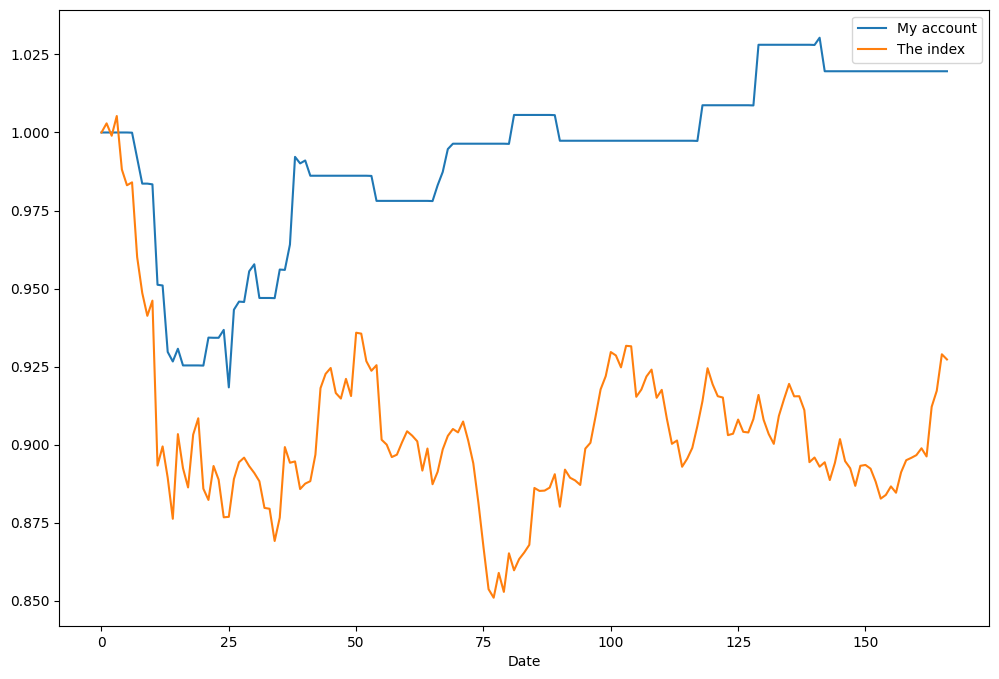

In [ ]:
import Draw
reload(Draw)
%matplotlib inline
index_value = list(index_df[index_df['trade_date']==test_date_min]['pre_close']) + list(index_df.sort_values('trade_date')['close'])
Draw.Draw_Market_Value_Change(0, account.market_value_all, index_value)

e:\Project\stock_market\Draw.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(8, 3))


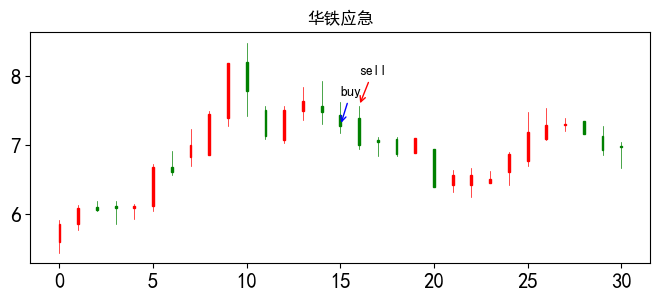

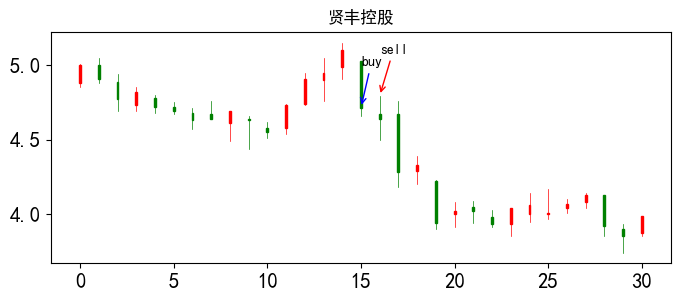

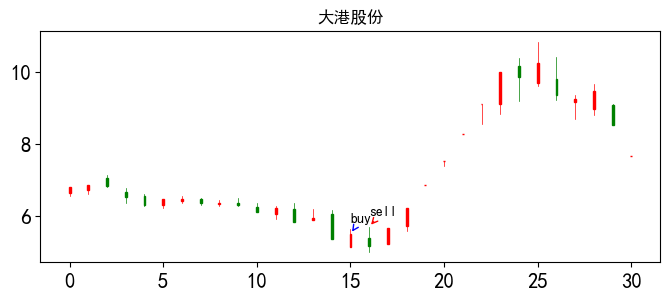

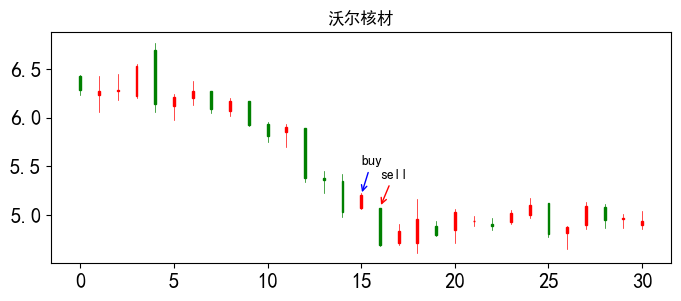

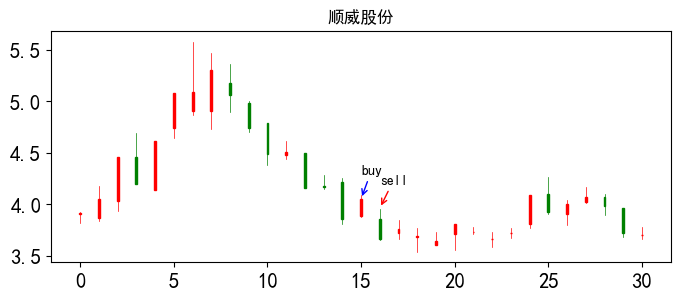

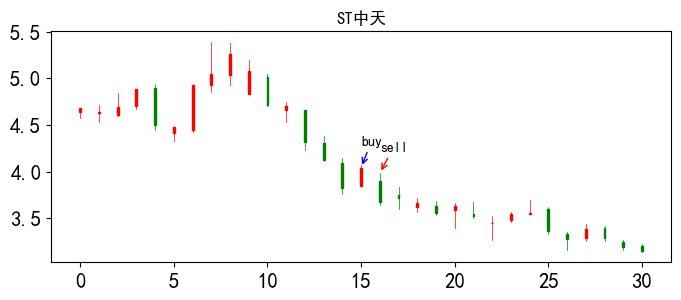

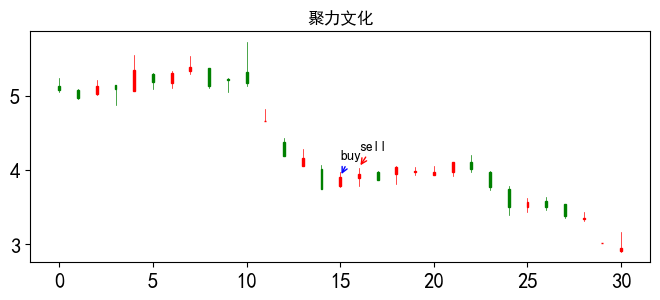

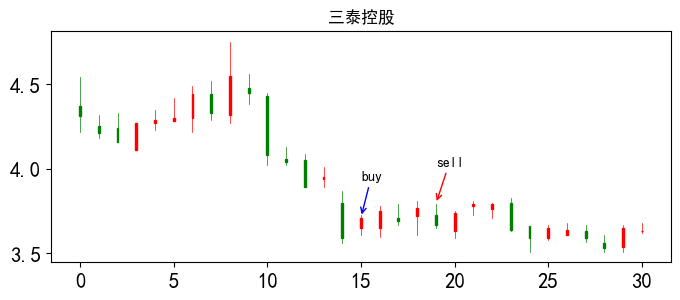

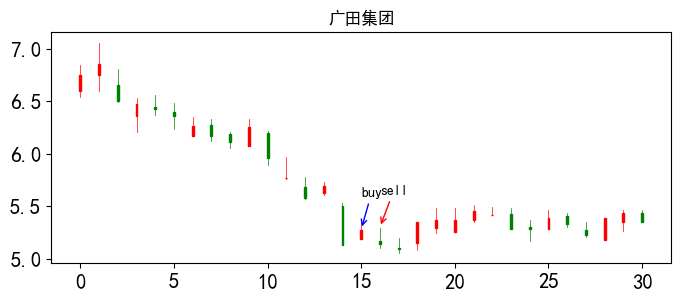

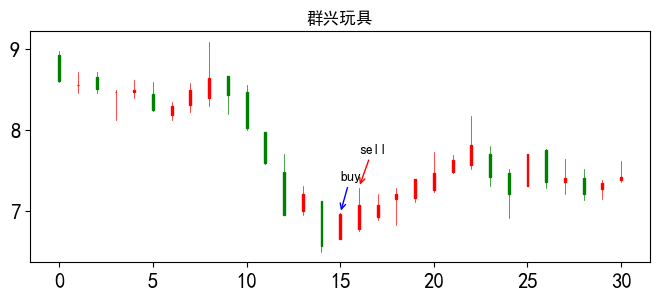

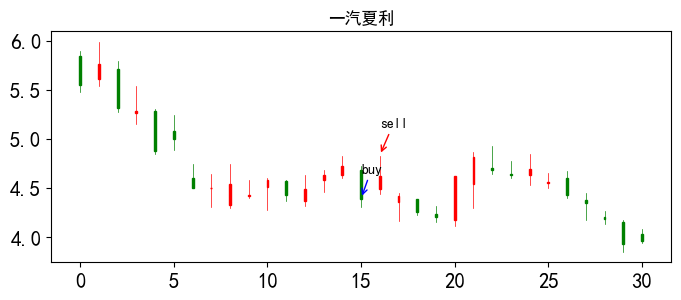

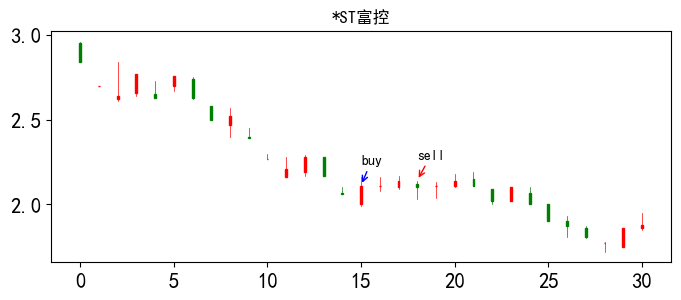

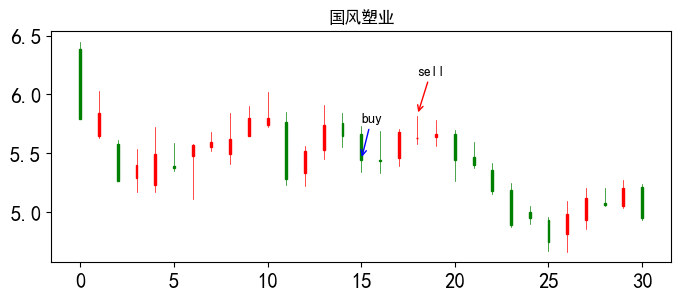

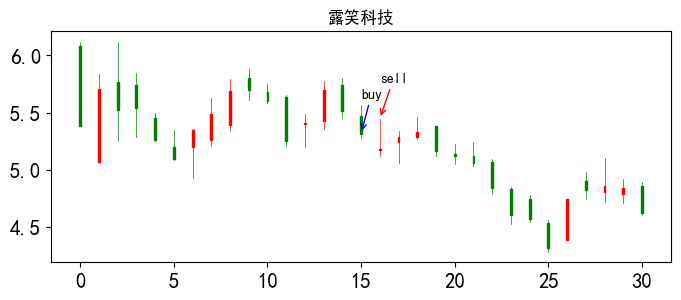

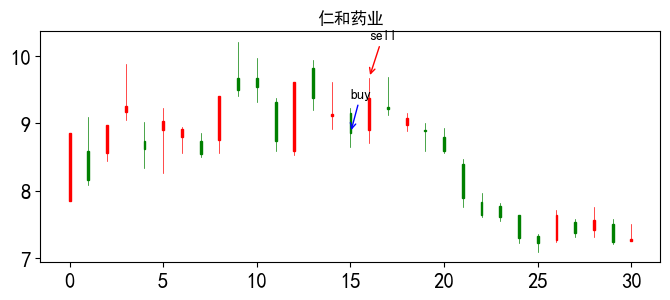

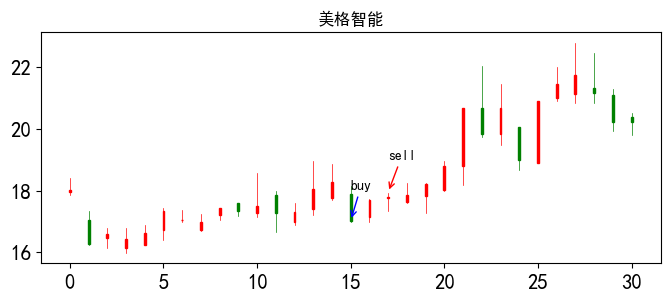

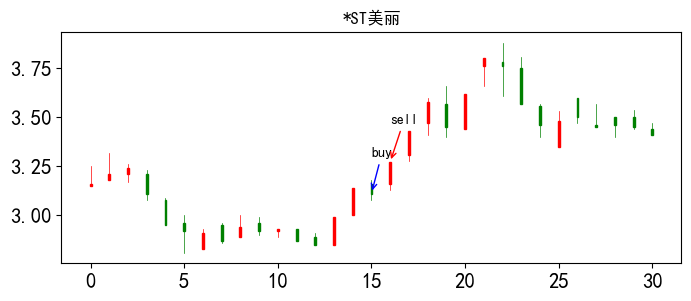

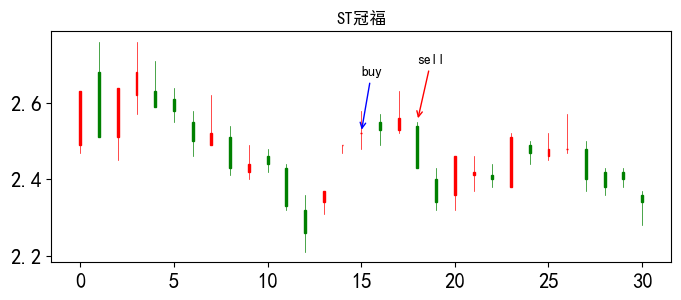

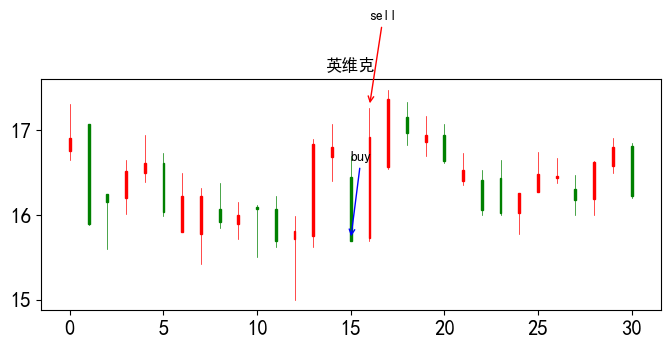

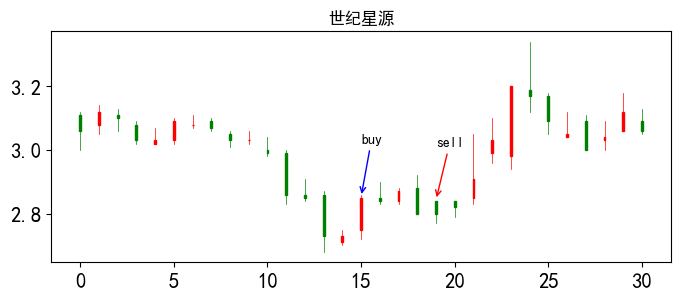

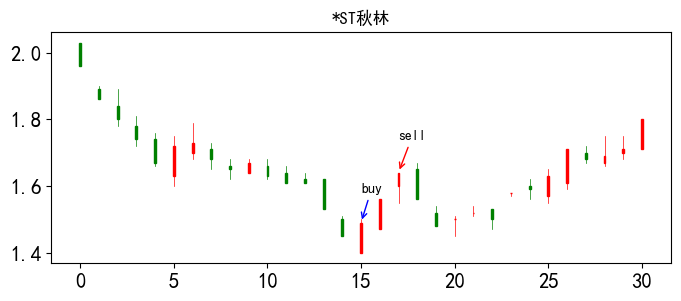

In [ ]:
num = 0
for ts_code, buy_date, sell_date in zip(account.info['ts_code'], account.info['buy_date'], account.info['sell_date']):
    Draw.Draw_Stock(ts_code, stock_info, buy_date, sell_date, left_offset=15, right_offset=15)
    num = num + 1
    if num > 20:
        break